In [1]:
import numpy as np
import sys
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import interferometer as itf
sys.path.append('../') # Add parent directory to the system path
from boson_sampling_probabilities import output_probability
from simulation import run_interferom_simulation, dist_to_state

from numeric_truncated_unitaries import numeric_truncated_unitary
from direct_decomposition import compile_unitary, knit_qiskit_circuits, random_unitary, direct_decomposition
from random import random
import qiskit.quantum_info as qi

In [2]:
def bs_matrix(BS):
    theta = BS.theta
    phi = BS.phi
    return np.array([[np.exp(1j *phi) * np.cos(theta),  -np.sin(theta)], 
                      [np.exp(1j * phi) * np.sin(theta), np.cos(theta)]])

def is_unitary(m):
    return np.allclose(np.eye(m.shape[0]), np.conjugate(np.transpose(m)) @ m)

[
 Beam splitter between modes 1 and 2: 
 Theta angle: 1.43 
 Phase: 1.46]


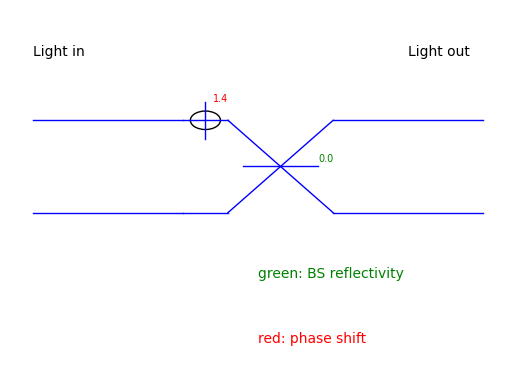

In [3]:
I = itf.Interferometer()
theta_1 = np.pi/2 * random()
phi_1 = np.pi * random()
BS1 = itf.Beamsplitter(1, 2, theta=theta_1, phi=phi_1)
I.add_BS(BS1)
print(I.BS_list)
I.draw()

In [7]:
U_BS = I.calculate_transformation()
ideal_U_circuit = numeric_truncated_unitary(BS1.theta, BS1.phi, 1)
BS_circuit = direct_decomposition(U_BS, 1)
BS_circuit.draw()
# U_circuit = qi.Operator(BS_circuit)
# np.allclose(ideal_U_circuit, U_circuit)

global phase: 5.4246
         ┌─────────────────────┐             ┌────────────────────┐         »
q_0: ────┤ U3(π/2,-π/2,2.2752) ├──────■──────┤ U3(1.7159,-π,-π/2) ├──────■──»
     ┌───┴─────────────────────┴───┐┌─┴─┐┌───┴────────────────────┴───┐┌─┴─┐»
q_1: ┤ U3(0.0013233,-π/2,-0.75842) ├┤ X ├┤ U3(1.5719,0.14514,-1.5695) ├┤ X ├»
     └─────────────────────────────┘└───┘└────────────────────────────┘└───┘»
«        ┌───────────────────┐    ░ 
«q_0: ───┤ U3(π/2,-2.2752,0) ├────░─
«     ┌──┴───────────────────┴──┐ ░ 
«q_1: ┤ U3(1.5721,-2.3832,-π/2) ├─░─
«     └─────────────────────────┘ ░

In [11]:
big_circuit = QuantumCircuit(3)
big_circuit.compose(BS_circuit, [0,1], inplace=True)
big_circuit.draw()

global phase: 5.4246
         ┌─────────────────────┐             ┌────────────────────┐         »
q_0: ────┤ U3(π/2,-π/2,2.2752) ├──────■──────┤ U3(1.7159,-π,-π/2) ├──────■──»
     ┌───┴─────────────────────┴───┐┌─┴─┐┌───┴────────────────────┴───┐┌─┴─┐»
q_1: ┤ U3(0.0013233,-π/2,-0.75842) ├┤ X ├┤ U3(1.5719,0.14514,-1.5695) ├┤ X ├»
     └─────────────────────────────┘└───┘└────────────────────────────┘└───┘»
q_2: ───────────────────────────────────────────────────────────────────────»
                                                                            »
«        ┌───────────────────┐    ░ 
«q_0: ───┤ U3(π/2,-2.2752,0) ├────░─
«     ┌──┴───────────────────┴──┐ ░ 
«q_1: ┤ U3(1.5721,-2.3832,-π/2) ├─░─
«     └─────────────────────────┘ ░ 
«q_2: ──────────────────────────────
«

In [23]:
qc = QuantumCircuit(3)
phase_operator = np.exp(-1j * phi_1) * np.eye(2) # Negative phases on diagonal
GP_flip = QuantumCircuit(2)
GP_flip.unitary(phase_operator, list(range(2)), label=f"correct_global_phase({-phi_1})") # Is a label necessary?
qc.compose(GP_flip, list(range(2)), inplace=True)
print(qc)

op= qi.Operator(qc)
for i in op.data:
    print(i)

     ┌──────────────────────────────────────────┐
q_0: ┤ correct_global_phase(-1.462864881165583) ├
     ├──────────────────────────────────────────┤
q_1: ┤ correct_global_phase(-1.462864881165583) ├
     └──────────────────────────────────────────┘
q_2: ────────────────────────────────────────────
                                                 
[-0.97679193-0.21419037j  0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j        ]
[ 0.        +0.j         -0.97679193-0.21419037j  0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j        ]
[ 0.        +0.j          0.        +0.j         -0.97679193-0.21419037j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j        ]
[ 0.        +0.j          0.        +0.j          0.        +0.j
 -0.97679193-0.21419037j  0.        +